In [ ]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=5b25accece949b709577fad8b63a0471fe0ad06b3071b5bce2a3e73677aa1180
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [ ]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

warnings.filterwarnings('ignore')

In [ ]:
class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 5
    output_dim = 1
    hidden_size = 2
    num_epochs = 100
    checkpoints_dir = './models/elliptic_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("Using device:", Config.device)

Using device: cpu


In [ ]:
df_features = pd.read_csv('/content/diabetes_features.csv', header=None)
df_edges = pd.read_csv("/content/diabetes_edges.csv")
df_classes =  pd.read_csv("/content/diabetes_target.csv")
#df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

In [ ]:
# merging node features DF with classes DF
df_merge = df_features.merge(df_classes, how='left', right_on="Node_id", left_on=0)
df_merge = df_merge.sort_values([0]).reset_index(drop=True)

# extracting classified/non-classified nodes
classified = df_merge.loc[df_merge['Outcome'].loc[df_merge['Outcome']!=2].index].drop('Node_id', axis=1)
unclassified = df_merge.loc[df_merge['Outcome'].loc[df_merge['Outcome']==2].index].drop('Node_id', axis=1)

# extracting classified/non-classified edges
classified_edges = df_edges.loc[df_edges['Node_id'].isin(classified[0]) & df_edges['Node_id_1'].isin(classified[0])]
unclassifed_edges = df_edges.loc[df_edges['Node_id'].isin(unclassified[0]) | df_edges['Node_id_1'].isin(unclassified[0])]

In [ ]:
# mapping nodes to indices
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)}

# mapping edges to indices
edges = df_edges.copy()
edges.Node_id = edges.Node_id.map(map_id)
edges.Node_id_1 = edges.Node_id_1.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)

Total amount of edges in DAG: torch.Size([2, 768])


In [ ]:
# maping node ids to corresponding indexes
node_features = df_merge.drop(['Node_id'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)

classified_idx = node_features['Outcome'].loc[node_features['Outcome']!=2].index
unclassified_idx = node_features['Outcome'].loc[node_features['Outcome']==2].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['Outcome'] = node_features['Outcome'].replace(2, 0) 

labels = node_features['Outcome'].values

# drop indeces, class and temporal axes 
node_features = torch.tensor(np.array(node_features.drop([0, 'Outcome', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)

In [ ]:
# converting data to PyGeometric graph data format
elliptic_dataset = Data(x = node_features, 
                        edge_index = edge_index, 
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32)) 

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 768
Number of node features: 5
Number of edges: 768
Number of edge features: 5
Average node degree: 1.00
Number of classes: 2
Has isolated nodes: True
Has self loops: True
Is directed: True


In [ ]:
y_train = labels[classified_idx]

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = \
    train_test_split(node_features[classified_idx], 
                     y_train, 
                     classified_idx, 
                     test_size=0.15, 
                     random_state=Config.seed, 
                     stratify=y_train)

In [ ]:
elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 652
Validation dataset size: 116
Test dataset size: 0


In [ ]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gcn2(h, edge_index)
        return out
    
class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GAT, self).__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads, dropout=0.6)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, concat=False, heads=1, dropout=0.6)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gat2(h, edge_index)
        return out
    
def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

In [ ]:
def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
        
            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index) 
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

In [ ]:
gcn_model = GCN(Config.input_dim, Config.hidden_size, Config.output_dim).to(Config.device)
data_train = elliptic_dataset.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_evaluate(gcn_model,
              data_train,
              criterion,
              optimizer,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gcn_best_model.pth.tar')

Epoch   0 | Train Loss: 0.858 | Train Acc:  64.72% | Val Loss: 0.78 | Val Acc: 66.38%
Saving model for best loss
Epoch  10 | Train Loss: 0.806 | Train Acc:  64.26% | Val Loss: 0.80 | Val Acc: 66.38%
Epoch  20 | Train Loss: 0.717 | Train Acc:  65.03% | Val Loss: 0.85 | Val Acc: 65.52%
Epoch  30 | Train Loss: 0.754 | Train Acc:  64.57% | Val Loss: 0.80 | Val Acc: 65.52%
Epoch  40 | Train Loss: 0.703 | Train Acc:  65.34% | Val Loss: 0.85 | Val Acc: 65.52%
Epoch  50 | Train Loss: 0.740 | Train Acc:  65.34% | Val Loss: 0.78 | Val Acc: 65.52%
Saving model for best loss
Epoch  60 | Train Loss: 0.729 | Train Acc:  64.88% | Val Loss: 0.69 | Val Acc: 66.38%
Saving model for best loss
Epoch  70 | Train Loss: 0.711 | Train Acc:  65.03% | Val Loss: 0.75 | Val Acc: 64.66%
Epoch  80 | Train Loss: 0.702 | Train Acc:  65.03% | Val Loss: 0.71 | Val Acc: 65.52%
Epoch  90 | Train Loss: 0.704 | Train Acc:  65.03% | Val Loss: 0.69 | Val Acc: 65.52%
Saving model for best loss
Epoch 100 | Train Loss: 0.683 | 

GCN(
  (gcn1): GCNConv(5, 2)
  (gcn2): GCNConv(2, 1)
)

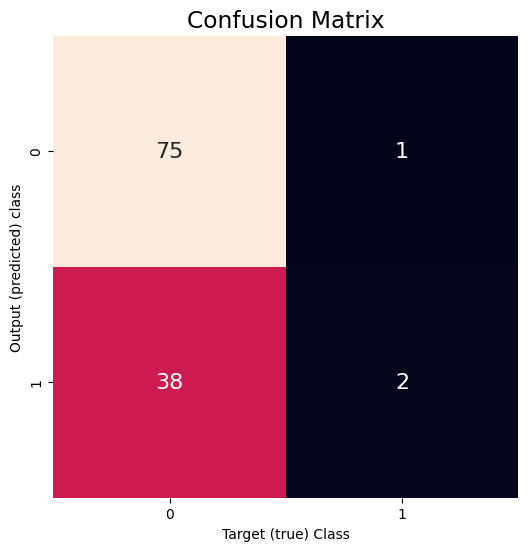

              precision    recall  f1-score   support

       licit       0.66      0.99      0.79        76
     illicit       0.67      0.05      0.09        40

    accuracy                           0.66       116
   macro avg       0.67      0.52      0.44       116
weighted avg       0.66      0.66      0.55       116



In [ ]:
gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gcn_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gcn_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx])

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx],
                            target_names=['Yes', 'No']))


#print(f"Test data fraud cases, percentage: {y_test_preds[data_train.test_idx].detach().cpu().numpy().sum() / len(data_train.y[data_train.test_idx]) *100})